In [1]:
import os
import sys
import faiss
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append(os.path.abspath(".."))

from utils.dataset.config import DatasetPath
from utils.dataset.domain import fashion
from utils.dataset.user_generator import generate_users
from utils.dataset.item_generator import generate_items

# Dataset Path
- `recsys/data/dataset/` 하위 경로 생성

In [2]:
current_dir = os.path.abspath(os.curdir)
base_dir = "/".join(current_dir.split("/")[:-1])
dataset_dir = Path(base_dir).joinpath("data/dataset")

paths = DatasetPath(base_dir=dataset_dir, dataset_name="fashion")

# User Metadata
- 가상의 사용자 데이터 생성

In [3]:
# 중앙값 근처로 많이 생성되는 삼각분포(기본)
df_user = generate_users(
    num_users=10000,
    age_range=(18, 60),
    genders=("M", "F"),
    gender_probs=(0.5, 0.5),
    seed=42,
)

# ---------- 피크 나이를 30세로 명시 ---------- #
# df_user_30peak = generate_users(
#     num_users=10000, age_range=(18, 70), age_mode=30, seed=42
# )

# ---------- 기존 균등분포로 생성하고 싶다면 ---------- #
# df_user_uniform = generate_users(
#     num_users=10000, age_range=(18, 70), age_distribution="uniform", seed=42
# )

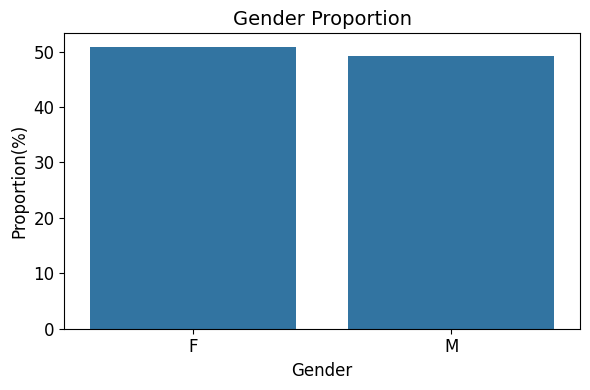

In [4]:
# 성별 분포
df_age_agg = df_user["gender"].value_counts(normalize=True).sort_index().reset_index()
df_age_agg["proportion"] = df_age_agg["proportion"] * 100

plt.figure(figsize=(6, 4), dpi=100)
sns.barplot(data=df_age_agg, x="gender", y="proportion")
plt.title("Gender Proportion", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Proportion(%)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

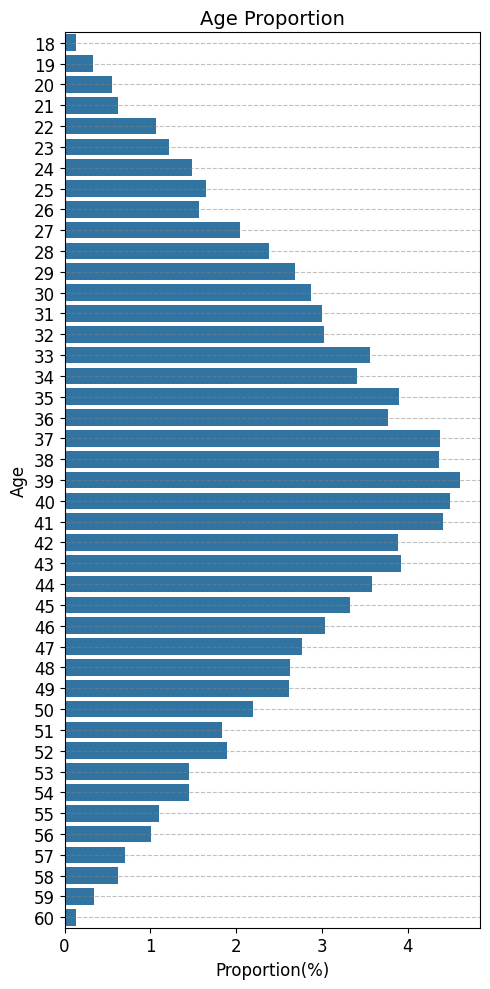

In [5]:
# 연령 분포
df_age_agg = df_user["age"].value_counts(normalize=True).sort_index().reset_index()
df_age_agg["age"] = df_age_agg["age"].astype(str)
df_age_agg["proportion"] = df_age_agg["proportion"] * 100

plt.figure(figsize=(5, 10), dpi=100)
sns.barplot(data=df_age_agg, x="proportion", y="age")
plt.title("Age Proportion", fontsize=14)
plt.xlabel("Proportion(%)", fontsize=12)
plt.ylabel("Age", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, axis="y", linestyle="--", color="grey", alpha=0.5)
plt.tight_layout()
plt.show()

In [6]:
df_user.to_parquet(paths.user_metadata_path)

# Item Metadata
- 가상의 상품 데이터 생성

In [7]:
# 상품 분류 속성 및 제목 생성
df_item = generate_items(fashion.Fashion, num_items=10000)
df_item.head()

,item_id,title,color,style,fit,material,season,sleeve,category
0,1,겨울 감성 세미오버핏 나일론 셔츠,네이비,모던,세미오버핏,나일론,겨울,숏슬리브,셔츠
1,2,여름 한정 데님 소재 그레이 원피스,그레이,댄디,슬림핏,데님,여름,민소매,원피스
2,3,베이지 컬러의 시크 스타일 데님 셔츠,베이지,시크,오버핏,데님,봄,민소매,셔츠
3,4,루즈핏 실루엣의 나일론 후드티,카키,시크,루즈핏,나일론,여름,롱슬리브,후드티
4,5,필수템! 레트로 무드의 겨울용 원피스,그레이,레트로,크롭핏,코튼,겨울,민소매,원피스


In [8]:
from dataclasses import fields

# 분류 속성 확인
columns = [f.name for f in fields(fashion.Fashion) if f.name != "name_templates"]
print(columns)

['color', 'style', 'fit', 'material', 'season', 'sleeve', 'category']


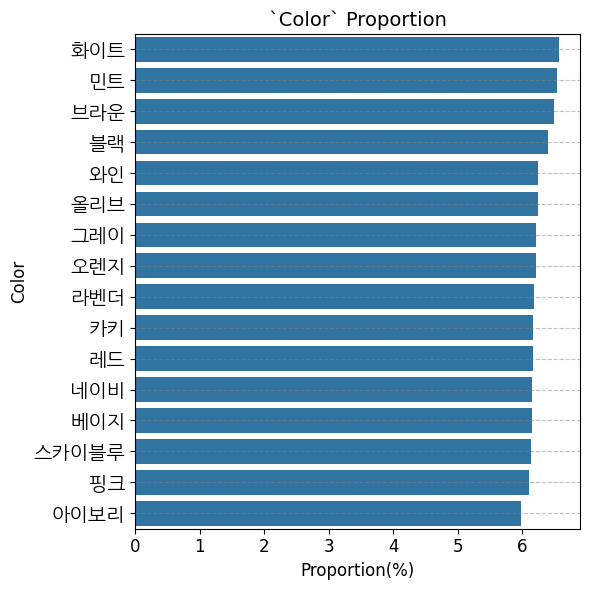

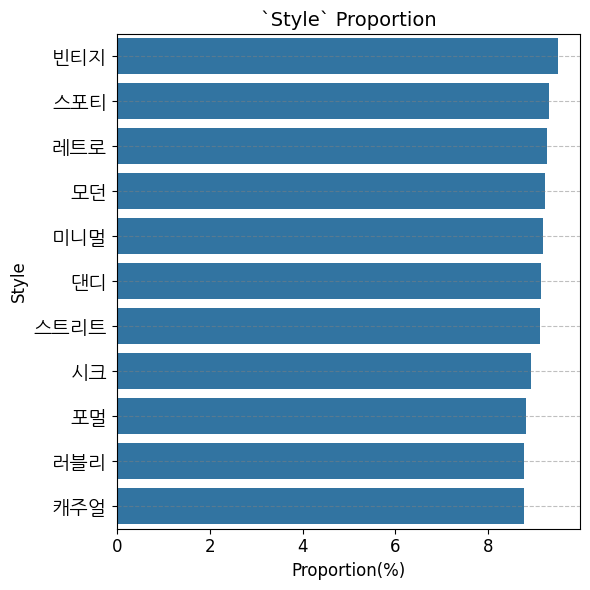

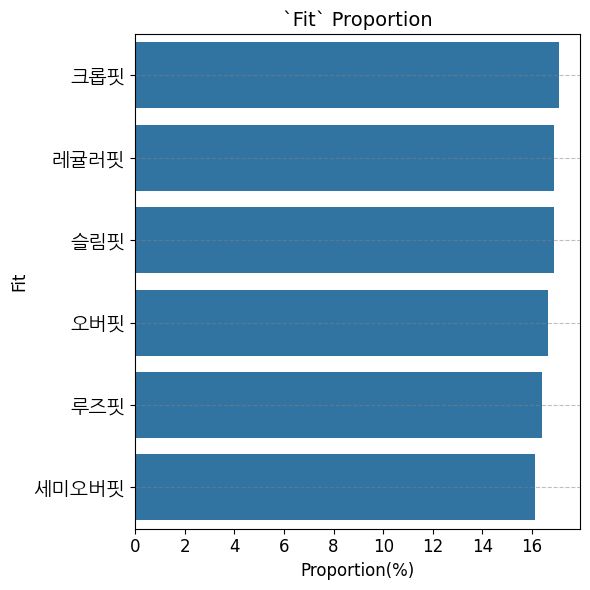

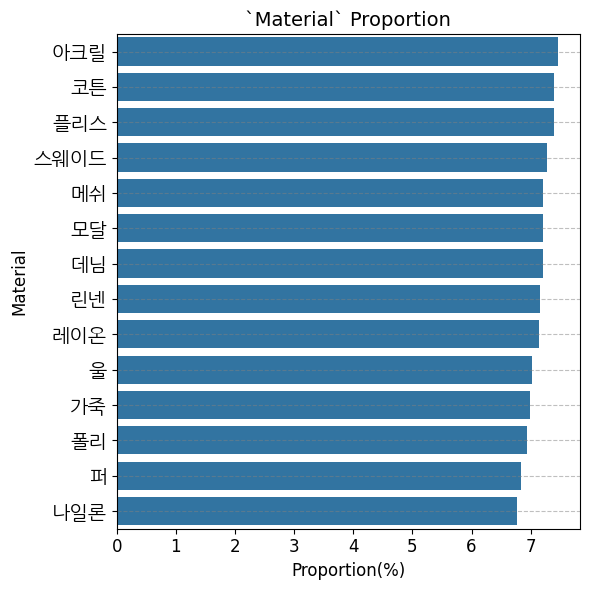

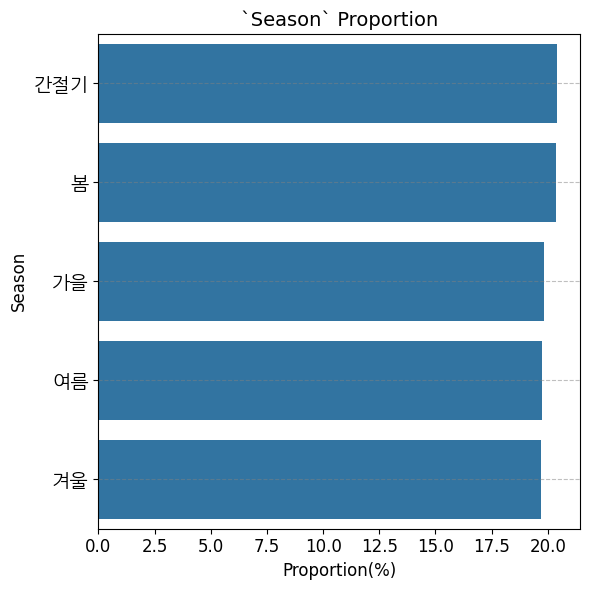

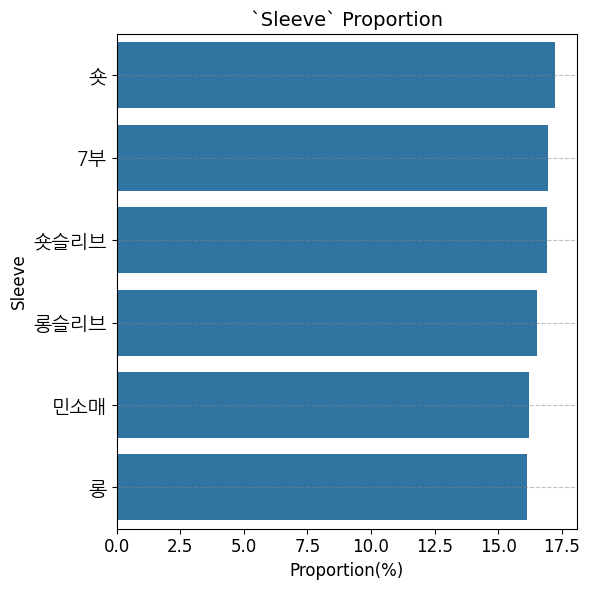

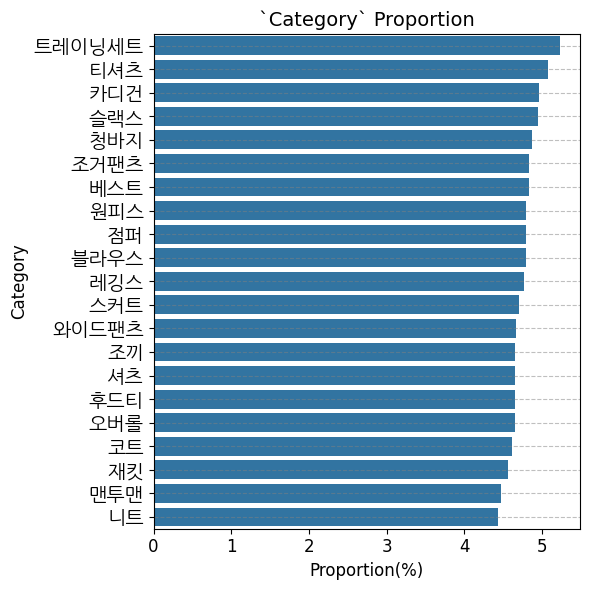

In [9]:
from matplotlib import font_manager

root_dir = "/".join(os.getcwd().split("/")[:-1])
font_path = font_path = Path(root_dir).joinpath("data/NanumGothic-Regular.ttf")
font_name = font_manager.FontProperties(fname=font_path).get_name()
fontprop = font_manager.FontProperties(fname=font_path, size=14)

# 분류 속성별 필드값 분포 확인
for col in columns:
    df_item[col].value_counts()
    df_agg = (
        df_item[col]
        .value_counts(normalize=True)
        .sort_values(ascending=False)
        .reset_index()
    )
    df_agg[col] = df_agg[col].astype(str)
    df_agg["proportion"] = df_agg["proportion"] * 100

    plt.figure(figsize=(6, 6), dpi=100)
    sns.barplot(data=df_agg, x="proportion", y=col)
    plt.title(f"`{col.capitalize()}` Proportion", fontsize=14)
    plt.xlabel("Proportion(%)", fontsize=12)
    plt.ylabel(col.capitalize(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, fontproperties=fontprop)
    plt.grid(True, axis="y", linestyle="--", color="grey", alpha=0.5)
    plt.tight_layout()
    plt.show()

## Text Vector
- Vector Similarity Search 기반 추천을 위한 상품 임베딩 벡터 생성

### SentenceTransformer

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df_item["title"].tolist(), normalize_embeddings=True)
embeddings = np.array(embeddings).astype("float32")
df_item["text_vector"] = embeddings.tolist()

dim = embeddings.shape[1]
print(f"임베딩 차원: {dim}")
index = faiss.IndexFlatIP(dim)
index.add(embeddings)


def find_similar_items(query_text: str, top_k: int = 5):
    query_vec = model.encode([query_text], normalize_embeddings=True).astype("float32")
    scores, indices = index.search(query_vec, top_k)

    print(f"\n[🔍 입력 상품명] {query_text}\n")
    print("[📌 유사한 상품]")
    for rank, idx in enumerate(indices[0]):
        sim_score = scores[0][rank]
        print(f"{rank+1}. {df_item.iloc[idx]['title']} (score: {sim_score:.4f})")


find_similar_items("화이트 반팔 티셔츠")
find_similar_items("여름 린넨 원피스")

임베딩 차원: 384

[🔍 입력 상품명] 화이트 반팔 티셔츠

[📌 유사한 상품]
1. 가을 슬림핏 화이트 폴리 롱 원피스 (score: 0.8854)
2. 가을 슬림핏 화이트 린넨 숏 셔츠 (score: 0.8537)
3. 가을 크롭핏 화이트 데님 숏슬리브 와이드팬츠 (score: 0.8477)
4. 가을 오버핏 화이트 모달 숏슬리브 와이드팬츠 (score: 0.8475)
5. 가을 크롭핏 화이트 울 롱슬리브 점퍼 (score: 0.8452)

[🔍 입력 상품명] 여름 린넨 원피스

[📌 유사한 상품]
1. 봄 슬림핏 브라운 린넨 숏 원피스 (score: 0.9439)
2. 여름 세미오버핏 베이지 데님 숏 원피스 (score: 0.9382)
3. 여름 오버핏 민트 린넨 숏슬리브 원피스 (score: 0.9335)
4. 여름 감성 슬림핏 메쉬 원피스 (score: 0.9318)
5. 여름 세미오버핏 블랙 데님 숏슬리브 원피스 (score: 0.9274)


### e5-base

In [11]:
from sentence_transformers import SentenceTransformer
import faiss

model = SentenceTransformer("intfloat/multilingual-e5-base")

corpus_texts = ["passage: " + t for t in df_item["title"].tolist()]
embeddings = model.encode(corpus_texts, normalize_embeddings=True)
embeddings = np.array(embeddings).astype("float32")
df_item["text_vector"] = embeddings.tolist()

dim = embeddings.shape[1]
print(f"임베딩 차원: {dim}")
index = faiss.IndexFlatIP(dim)
index.add(embeddings)


def find_similar_items(query_text: str, top_k: int = 5):
    query_vec = model.encode(
        ["query: " + query_text], normalize_embeddings=True
    ).astype("float32")
    scores, indices = index.search(query_vec, top_k)

    print(f"\n[🔍 입력 상품명] {query_text}\n")
    print("[📌 유사한 상품]")
    for rank, idx in enumerate(indices[0]):
        sim_score = scores[0][rank]
        print(f"{rank + 1}. {df_item.iloc[idx]['title']} (score: {sim_score:.4f})")


find_similar_items("화이트 반팔 티셔츠")
find_similar_items("여름 린넬 원피스")

임베딩 차원: 768

[🔍 입력 상품명] 화이트 반팔 티셔츠

[📌 유사한 상품]
1. 화이트 컬러의 빈티지 스타일 가죽 티셔츠 (score: 0.8716)
2. 가을에 어울리는 화이트 티셔츠 (score: 0.8709)
3. 간절기에 어울리는 화이트 티셔츠 (score: 0.8687)
4. 겨울에 어울리는 화이트 티셔츠 (score: 0.8674)
5. 봄에 어울리는 화이트 티셔츠 (score: 0.8621)

[🔍 입력 상품명] 여름 린넬 원피스

[📌 유사한 상품]
1. 여름 한정 린넨 소재 올리브 원피스 (score: 0.8825)
2. 여름 시즌, 모던 무드의 네이비 린넨 7부 레귤러핏 원피스 (score: 0.8741)
3. 여름 시즌, 러블리 무드의 그레이 린넨 숏 오버핏 원피스 (score: 0.8733)
4. 여름에 어울리는 레드 원피스 (score: 0.8724)
5. 여름 시즌, 빈티지 무드의 라벤더 린넨 숏슬리브 크롭핏 원피스 (score: 0.8700)


In [12]:
df_text_vectors = df_item[["item_id", "text_vector"]]
df_text_vectors.to_parquet(paths.text_vectors_path)

df_item.drop(columns=["text_vector"]).to_parquet(paths.item_metadata_path)

## Image Vector
- Vector Similarity Search 기반 추천을 위한 상품 임베딩 벡터 생성

In [13]:
# 생략